In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import copy
import sys
# temporarily append the directory of the pycaffe wrapper (lrp_toolbox/caffe-master-lrp/python) to the PYTHONPATH
sys.path.append('../python')
import caffe

from utils import lrp_opts,load_model,get_target_indices, cropped_imagenet_mean,split_into_batches, transform_input, lrp_hm, normalize_color_hm, process_raw_heatmaps

# global variables to make this demo more convient to use
IMAGENET_MEAN_LOCATION  = '../python/caffe/imagenet/ilsvrc_2012_mean.npy'
EXAMPLE_IMAGE_FOLDER    = 'someimages'
MODEL                   = 'unsupervised' #unsupervised                                        # options: ('googlenet' | 'caffenet')
                                                                            # - for caffenet, execute download_model.sh prior to this script
                                                                            # - for googlenet, a pre-trained model can be downloaded from http://dl.caffe.berkeleyvision.org/bvlc_googlenet.caffemodel
num_images = len(os.listdir(EXAMPLE_IMAGE_FOLDER))
"""
Simple example to demonstrate the LRP methods using the Caffe python interface.
Calculates the prediction and LRP heatmap for num_images of example imaages from the EXAMPLE_IMAGE_FOLDER
"""


# load the pre-trained model
net = load_model(model = MODEL)
if MODEL == 'googlenet':
    in_hei = 224
    in_wid = 224
else:
    # default: caffenet
    in_hei = 227
    in_wid = 227

# load imagenet mean and crop it to fit the networks input dimensions
cropped_mean = cropped_imagenet_mean(IMAGENET_MEAN_LOCATION, in_hei, in_wid)

# load example iamge
image_paths = [os.path.join(EXAMPLE_IMAGE_FOLDER, EXAMPLE_IMAGE_PATH) for EXAMPLE_IMAGE_PATH in os.listdir(EXAMPLE_IMAGE_FOLDER)[:num_images]]
example_images = [Image.open(img_pth) for img_pth in image_paths]

# preprocess image to fit caffe input convention (subtract mean, swap input dimensions (input blob convention is NxCxHxW), transpose color channels to BGR)
transformed_input = np.array([transform_input(example_image, True, True, in_hei = in_hei, in_wid = in_wid, mean=cropped_mean)for example_image in example_images])

# adapt caffe batchsize to avoid unnecessary computations
net.blobs['data'].reshape(*transformed_input.shape)

# classification (forward pass)
# the lrp_hm convenience method always performs a forward pass anyways, the output here is only used to output the top predictions later
net.blobs['data'].data[...] = transformed_input
out = net.forward()
top_predictions = np.argmax(out['prob'], axis=1)


## ############# ##
# LRP parameters: #
## ############# ##
lrp_type    = 'epsilon' #epsilon #eps_n_flat
# lrp_type              | meaning of lrp_param  | uses switch_layer | description 
# ---------------------------------------------------------------------------
# epsilon               | epsilon               | no                | epsilon lrp
# alphabeta             | beta                  | no                | alphabeta lrp, alpha = 1-beta
# eps_n_flat            | epsilon               | yes               | epsilon lrp until switch_layer,   wflat lrp for all layers below
# eps_n_wsquare         | epsilon               | yes               | epsilon lrp until switch_layer,   wsquare lrp for all layers below
# ab_n_flat             | beta                  | yes               | alphabeta lrp until switch_layer, wflat lrp for all layers below
# ab_n_wsquare          | beta                  | yes               | alphabeta lrp until switch_layer, wsquare lrp for all layers below
# eps_n_ab              | (epsilon, beta)       | yes               | epsilon lrp until switch_layer, alphabeta lrp for all layers below
# layer_dep             | (epsilon, beta)       | no                | epsilon lrp for all fully-connected layers, alphabeta lrp with alpha=1 for all convolution layerrs
# layer_dep_n_flat      | (epsilon, beta)       | yes               | layer_dep (see above) until switch_layer, wflat lrp for all layers below
# layer_dep_n_wsquare   | (epsilon, beta)       | yes               | layer_dep (see above) until switch-layer, wsquare lrp for all layers below

# depending on lrp_type, lrp_param needs to be a scalar or a tuple (see table above). If a scalar is given to an lrp_type that expects a tuple, the default epsilon=0., alpha=0. 
lrp_param   =   1e-10

# switch_layer param only needed for the composite methods
# the parameter depicts the first layer for which the second formula type is used.
# interesting values for caffenet are: 0, 4, 8, 10, 12 | 15, 18, 21 (convolution layers | innerproduct layers)
switch_layer = 13  #13 #22 #21  # unsupervised net 17


path= "/media/liang/ssd/action_3/extract_feature/all_data_save_matrix/ArmFlapping_index.txt"
path= "/media/liang/ssd/action_3/extract_feature/all_data_save_matrix/HeadBanging_index.txt"
path= "/media/liang/ssd/action_3/extract_feature/all_data_save_matrix/Spinning_index.txt"




classind    =  -1    #-1    #100          # (class index  | -1 for top_class)


## ################################## ##
# Heatmap calculation and presentation #
## ################################## ##

# LRP
#backward = lrp_hm(net, transformed_input, lrp_method=lrp_type, lrp_param=lrp_param, target_class_inds=classind, switch_layer=switch_layer)

#backward = lrp_hm(net, transformed_input, lrp_method=lrp_type, lrp_param=lrp_param, target_class_inds=classind, switch_layer=switch_layer)

#def lrp_hm(net, input_images, lrp_method = 'epsilon', lrp_param = 0.0000001, target_class_inds = -1, switch_layer = -1, single_mode=False, verbose_output= False):
input_images=transformed_input
lrp_method=lrp_type
lrp_param=lrp_param
target_class_inds=classind
switch_layer=switch_layer
single_mode=False
verbose_output= False


input_shape = input_images.shape
network_batch_shape = net.blobs['data'].data.shape

if isinstance( target_class_inds, int):
    print('Using the same target class {} for all inputs in the batch.'.format(target_class_inds))
else:
    assert(target_class_inds.shape[0] == input_images.shape[0])
    print('Individual classind given for each input')

if single_mode:
    og_batch_size = int(network_batch_shape[0])
    net.blobs['data'].reshape(1, network_batch_shape[1], network_batch_shape[2], network_batch_shape[3])
    net.reshape()
    # print('Changed batchsize to {}'.format(1))

batch_size = net.blobs['data'].shape[0]
input_batches = split_into_batches(input_images, batch_size)
output = []

num_batches = len(input_batches)

if not single_mode:
    print('...start batch processing with batchsize {}'.format(batch_size))

for b_i, input_image_batch in enumerate(input_batches):

    if not single_mode and verbose_output:
        print('batch ({}/{})'.format(b_i+1, num_batches))

    # test prediction:
    original_shape = net.blobs['data'].shape

    # last batch can be smaller: adapt network input size for this batch
    tmp_reduced_batchsize = False
    if original_shape[0] != input_image_batch.shape[0]:
        net.blobs['data'].reshape(input_image_batch.shape[0], original_shape[1], original_shape[2], original_shape[3])
        net.reshape()
        tmp_reduced_batchsize = True
        # print('Changed batchsize to {}'.format(input_image_batch.shape[0]))

    net.blobs['data'].data[...] = input_image_batch
    out = net.forward()  #(1, 1000)  out['prob']

    target_class = get_target_indices(target_class_inds, out['prob'])

    if single_mode:

        if switch_layer > 0 and lrp_method != 'epsilon' and lrp_method != 'alphabeta':
            lrpopts =  lrp_opts(lrp_method, lrp_param, switch_layer = switch_layer) 
            if lrpopts is None:
                print('Invalid lrp parameter setting, check lrp_type and lrp_param')
            relevance = net.lrp_single(int(target_class[0]), lrpopts)
        else:
            lrpopts =  lrp_opts(lrp_method, lrp_param) 
            if lrpopts is None:
                print('Invalid lrp parameter setting, check lrp_type and lrp_param')
            relevance = net.lrp_single(int(target_class[0]), lrpopts)

    else:

        if switch_layer > 0 and lrp_method != 'epsilon' and lrp_method != 'alphabeta':
            lrpopts =  lrp_opts(lrp_method, lrp_param, switch_layer = switch_layer) 
            if lrpopts is None:
                print('Invalid lrp parameter setting, check lrp_type and lrp_param')
            relevance = net.lrp(target_class, lrpopts)
        else:
            lrpopts =  lrp_opts(lrp_method, lrp_param) 
            if lrpopts is None:
                print('Invalid lrp parameter setting, check lrp_type and lrp_param')
            relevance = net.lrp(target_class, lrpopts)

    output.append(relevance)

    # revert network input change for the smaller batch
    if tmp_reduced_batchsize:
        net.blobs['data'].reshape(original_shape[0], original_shape[1], original_shape[2], original_shape[3])
        net.reshape()
        # print('Changed batchsize to {}'.format(original_shape[0]))

output = np.concatenate(output)

if single_mode:
    net.blobs['data'].reshape(og_batch_size, network_batch_shape[1], network_batch_shape[2], network_batch_shape[3])
    net.reshape()
    # print('Changed batchsize to {}'.format(og_batch_size))


backward=output




if backward is None:
    print('----------ERROR-------------')
    print('LRP result is None, check lrp_type and lrp_param for corectness')

sum_over_channels  = True
normalize_heatmap  = False

if lrp_type in ['deconv', 'guided_backprop']:
    sum_over_channels = False
    normalize_heatmap  = True

# post-process the relevance values
heatmaps = process_raw_heatmaps(backward, normalize=normalize_heatmap, sum_over_channels=sum_over_channels)

#heatmaps = process_raw_heatmaps(backward, normalize=normalize_heatmap, sum_over_channels=sum_over_channels)

for im_idx in range(num_images):

    if classind == -1:
        print('top class!')
        target_index = top_predictions[im_idx]
    else:
        target_index = classind

    # stretch input to input dimensions (only for visualization)
    stretched_input = transform_input(example_images[im_idx], False, False, in_hei = in_hei, in_wid = in_wid, mean=cropped_mean)
    heatmap = heatmaps[im_idx]

    # presentation
    fig=plt.subplot(1,2,1)
    plt.title('Prediction: {}'.format(top_predictions[im_idx]))
    plt.imshow(stretched_input)
    plt.axis('off')

    # normalize heatmap for visualization
    max_abs = np.max(np.absolute(heatmap))
    norm = mpl.colors.Normalize(vmin = -max_abs, vmax = max_abs)

    plt.subplot(1,2,2)

    if lrp_type in ['epsilon', 'alphabeta', 'eps', 'ab']:
        plt.title('{}-LRP heatmap for class {}'.format(lrp_type, target_index))

    if lrp_type in ['eps_n_flat', 'eps_n_square', 'std_n_ab']:
        if lrp_type == 'eps_n_flat':
            first_method    = 'epsilon'
            second_method   = 'wflat'

        elif lrp_type == 'eps_n_square':
            first_method    = 'epsilon'
            second_method   = 'wsquare'

        elif lrp_type == 'std_n_ab':
            first_method    = 'epsilon'
            second_method   = 'alphabeta'

        plt.title('LRP heatmap for class {}\nstarting with {}\n {} from layer {} on.'.format(target_index, first_method, second_method, switch_layer))

    if sum_over_channels:
        # relevance values are averaged over the pixel channels, use a 1-channel colormap (seismic)
        plt.imshow(heatmap[...,0], cmap='seismic', norm=norm, interpolation='none')
    else:
        # 1 relevance value per color channel
        heatmap = normalize_color_hm(heatmap)
        plt.imshow(heatmap, interpolation = 'none')

    plt.axis('off')
    plt.show()
    #fig.savefig('/home/liang/install/to.png')   # save the figure to file

In [4]:
#backward = lrp_hm(net, transformed_input, lrp_method=lrp_type, lrp_param=lrp_param, target_class_inds=classind, switch_layer=switch_layer)

#def lrp_hm(net, input_images, lrp_method = 'epsilon', lrp_param = 0.0000001, target_class_inds = -1, switch_layer = -1, single_mode=False, verbose_output= False):
input_images=transformed_input
lrp_method=lrp_type
lrp_param=lrp_param
target_class_inds=classind
switch_layer=switch_layer
single_mode=False
verbose_output= False


input_shape = input_images.shape
network_batch_shape = net.blobs['data'].data.shape

if isinstance( target_class_inds, int):
    print('Using the same target class {} for all inputs in the batch.'.format(target_class_inds))
else:
    assert(target_class_inds.shape[0] == input_images.shape[0])
    print('Individual classind given for each input')

if single_mode:
    og_batch_size = int(network_batch_shape[0])
    net.blobs['data'].reshape(1, network_batch_shape[1], network_batch_shape[2], network_batch_shape[3])
    net.reshape()
    # print('Changed batchsize to {}'.format(1))

batch_size = net.blobs['data'].shape[0]
input_batches = split_into_batches(input_images, batch_size)
output = []

num_batches = len(input_batches)

if not single_mode:
    print('...start batch processing with batchsize {}'.format(batch_size))

for b_i, input_image_batch in enumerate(input_batches):

    if not single_mode and verbose_output:
        print('batch ({}/{})'.format(b_i+1, num_batches))

    # test prediction:
    original_shape = net.blobs['data'].shape

    # last batch can be smaller: adapt network input size for this batch
    tmp_reduced_batchsize = False
    if original_shape[0] != input_image_batch.shape[0]:
        net.blobs['data'].reshape(input_image_batch.shape[0], original_shape[1], original_shape[2], original_shape[3])
        net.reshape()
        tmp_reduced_batchsize = True
        # print('Changed batchsize to {}'.format(input_image_batch.shape[0]))

    net.blobs['data'].data[...] = input_image_batch
    out = net.forward()  #(1, 1000)  out['prob']

    target_class = get_target_indices(target_class_inds, out['prob'])

    if single_mode:

        if switch_layer > 0 and lrp_method != 'epsilon' and lrp_method != 'alphabeta':
            lrpopts =  lrp_opts(lrp_method, lrp_param, switch_layer = switch_layer) 
            if lrpopts is None:
                print('Invalid lrp parameter setting, check lrp_type and lrp_param')
            relevance = net.lrp_single(int(target_class[0]), lrpopts)
        else:
            lrpopts =  lrp_opts(lrp_method, lrp_param) 
            if lrpopts is None:
                print('Invalid lrp parameter setting, check lrp_type and lrp_param')
            relevance = net.lrp_single(int(target_class[0]), lrpopts)

    else:

        if switch_layer > 0 and lrp_method != 'epsilon' and lrp_method != 'alphabeta':
            lrpopts =  lrp_opts(lrp_method, lrp_param, switch_layer = switch_layer) 
            if lrpopts is None:
                print('Invalid lrp parameter setting, check lrp_type and lrp_param')
            relevance = net.lrp(target_class, lrpopts)
        else:
            lrpopts =  lrp_opts(lrp_method, lrp_param) 
            if lrpopts is None:
                print('Invalid lrp parameter setting, check lrp_type and lrp_param')
            relevance = net.lrp(target_class, lrpopts)

    output.append(relevance)

    # revert network input change for the smaller batch
    if tmp_reduced_batchsize:
        net.blobs['data'].reshape(original_shape[0], original_shape[1], original_shape[2], original_shape[3])
        net.reshape()
        # print('Changed batchsize to {}'.format(original_shape[0]))

output = np.concatenate(output)

if single_mode:
    net.blobs['data'].reshape(og_batch_size, network_batch_shape[1], network_batch_shape[2], network_batch_shape[3])
    net.reshape()
    # print('Changed batchsize to {}'.format(og_batch_size))


backward=output


Using the same target class -1 for all inputs in the batch.
...start batch processing with batchsize 75


top class!


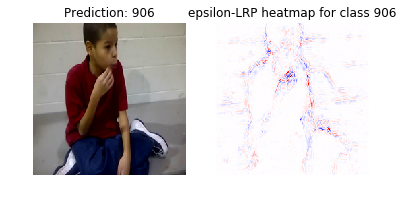

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

In [5]:




if backward is None:
    print('----------ERROR-------------')
    print('LRP result is None, check lrp_type and lrp_param for corectness')

sum_over_channels  = True
normalize_heatmap  = False

if lrp_type in ['deconv', 'guided_backprop']:
    sum_over_channels = False
    normalize_heatmap  = True

# post-process the relevance values
heatmaps = process_raw_heatmaps(backward, normalize=normalize_heatmap, sum_over_channels=sum_over_channels)

#heatmaps = process_raw_heatmaps(backward, normalize=normalize_heatmap, sum_over_channels=sum_over_channels)

for im_idx in range(num_images):

    if classind == -1:
        print('top class!')
        target_index = top_predictions[im_idx]
    else:
        target_index = classind

    # stretch input to input dimensions (only for visualization)
    stretched_input = transform_input(example_images[im_idx], False, False, in_hei = in_hei, in_wid = in_wid, mean=cropped_mean)
    heatmap = heatmaps[im_idx]

    # presentation
    fig=plt.subplot(1,2,1)
    plt.title('Prediction: {}'.format(top_predictions[im_idx]))
    plt.imshow(stretched_input)
    plt.axis('off')

    # normalize heatmap for visualization
    max_abs = np.max(np.absolute(heatmap))
    norm = mpl.colors.Normalize(vmin = -max_abs, vmax = max_abs)

    plt.subplot(1,2,2)

    if lrp_type in ['epsilon', 'alphabeta', 'eps', 'ab']:
        plt.title('{}-LRP heatmap for class {}'.format(lrp_type, target_index))

    if lrp_type in ['eps_n_flat', 'eps_n_square', 'std_n_ab']:
        if lrp_type == 'eps_n_flat':
            first_method    = 'epsilon'
            second_method   = 'wflat'

        elif lrp_type == 'eps_n_square':
            first_method    = 'epsilon'
            second_method   = 'wsquare'

        elif lrp_type == 'std_n_ab':
            first_method    = 'epsilon'
            second_method   = 'alphabeta'

        plt.title('LRP heatmap for class {}\nstarting with {}\n {} from layer {} on.'.format(target_index, first_method, second_method, switch_layer))

    if sum_over_channels:
        # relevance values are averaged over the pixel channels, use a 1-channel colormap (seismic)
        plt.imshow(heatmap[...,0], cmap='seismic', norm=norm, interpolation='none')
    else:
        # 1 relevance value per color channel
        heatmap = normalize_color_hm(heatmap)
        plt.imshow(heatmap, interpolation = 'none')

    plt.axis('off')
    plt.show()
    fig.savefig('/home/liang/install/to.png')   # save the figure to file

In [ ]:

for im_idx in range(num_images):

    if classind == -1:
        print('top class!')
        target_index = top_predictions[im_idx]
    else:
        target_index = classind

    # stretch input to input dimensions (only for visualization)
    stretched_input = transform_input(example_images[im_idx], False, False, in_hei = in_hei, in_wid = in_wid, mean=cropped_mean)
    heatmap = heatmaps[im_idx]